# Simple regression model

In [1]:
from toolbox import *

import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random

In [2]:
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [3]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectKBest, f_regression, RFECV, SelectFromModel

from sklearn.model_selection import GridSearchCV

In [4]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

## Load data

In [5]:
ws = load_weather_station_data('./data/weather_station_list.csv')
w = load_weather_data('./data/weather_collections/weather_daily_region.csv')

gs = load_groundwater_station_data('./data/groundwater/bergstraße/gw_stations_bergstraße.csv')
g = load_groundwater_data('./data/groundwater/bergstraße/gw.csv')

gs_agg = calc_aggregate_station_data(gs, g)
# setting more years improves model predictions
gs_agg = calc_initial_station_data(gs_agg, g, initial_n_years=5) 


### Create regional clusters from gw stations

A good number of clusters is 10-12. Re-run if station data is changed.

In [6]:
#explore_clusters(gs_agg[['x', 'y']])

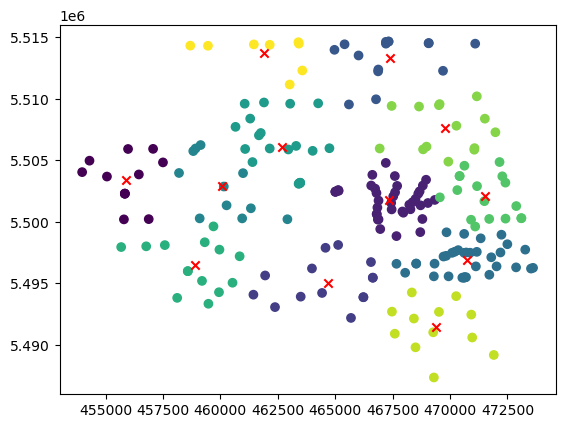

In [7]:
labels, centers = apply_clusters(gs_agg[['x', 'y']], 12, scale=False)

plot_clusters(gs_agg[['x', 'y']], labels, centers)

# Add clusters to stations
gs_agg['reg_clusters'] = labels
#gs_agg['reg_clusters'] = 0

### Merge data

In [8]:
g_merged = merge_groundwater_data(g, gs_agg)
#g_merged.describe()

In [9]:
#g_merged.head()

In [10]:
m = pd.merge(g_merged, w,
             how='left', left_index=True, right_index=True)

# restrict data to the post-war period
m = m.loc[m.date > pd.to_datetime('1950-01-01')]

# drop all rows with a date after the weather data cutoff date
m = m.loc[m.date <= pd.to_datetime('2022-12-31')]

m = m.dropna(subset=['station_id_count'])

m['week_of_year'] = m['date'].dt.isocalendar().week

In [11]:
#m.info()

In [12]:
#m.describe()

## Create intuitive dummy model

As baseline, we can assume that water_depth is proportional to temp.

In [13]:
def dummy_model(t):
    return 0.05 * t + 2

dummy_model(10)

2.5

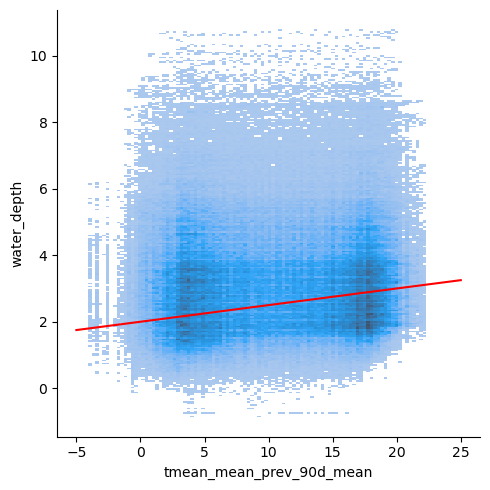

In [14]:
m_plot = m[['tmean_mean_prev_90d_mean', 'water_depth']].reset_index()
m_plot

sns.displot(data=m_plot, x='tmean_mean_prev_90d_mean', y='water_depth')
            
# works but is very slow (takes 10 minutes)
#sns.kdeplot(data=m_plot, 
#            x='tmean_mean_prev_30d_mean', y='water_depth',
               #alpha=0.01
#           )

x1, x2 = -5, 25
plt.plot([x1, x2],[dummy_model(x1), dummy_model(x2)], 'r');
            

## Train-test split

In [15]:
m.columns.unique()

Index(['station_id', 'date', 'water_dist', 'water_level', 'water_depth',
       'water_temp', 'x', 'y', 'start_date', 'end_date', 'ground_elev',
       'measure_elev', 'lifespan', 'geometry', 'water_level_mean',
       'water_depth_mean', 'water_temp_mean', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'reg_clusters', 'water_depth_anomaly',
       'station_id_count', 'precip_mean', 'precip_min', 'precip_max',
       'precip_std', 'tmean_mean', 'tmean_min', 'tmean_max', 'tmean_std',
       'tmax_mean', 'tmax_min', 'tmax_max', 'tmax_std', 'tmin_mean',
       'tmin_min', 'tmin_max', 'tmin_std', 'moisture_mean', 'moisture_min',
       'moisture_max', 'moisture_std', 'precip_mean_prev_2d_sum',
       'precip_mean_prev_7d_sum', 'precip_mean_prev_30d_sum',
       'precip_mean_prev_90d_sum', 'precip_mean_prev_1y_sum',
       'precip_mean_prev_3y_sum', 'tmean_mean_prev_2d_mean',
       'tmean_mean_prev_7d_mean'

In [16]:
# restrict data to these columns
df = m[['station_id',
        'date',
        'water_depth',
        'ground_elev',
        'x', 'y',
        'geometry',
        'reg_clusters',
        'ini_years_water_depth_mean',
        'ini_years_water_depth_std',
        'ini_years_water_depth_min',
        'ini_years_water_depth_max',
        'precip_mean',
        'tmean_mean',
        'moisture_mean',
        'precip_mean_prev_2d_sum',
        'precip_mean_prev_7d_sum',
        'precip_mean_prev_30d_sum',
        'precip_mean_prev_90d_sum',
        'precip_mean_prev_1y_sum',
        'precip_mean_prev_3y_sum',
        'tmean_mean_prev_2d_mean',
        'tmean_mean_prev_7d_mean',
        'tmean_mean_prev_30d_mean',
        'tmean_mean_prev_90d_mean',
        'tmean_mean_prev_1y_mean',
        'tmean_mean_prev_3y_mean'
       ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 535080 entries, 1950-01-02 to 2022-12-31
Data columns (total 27 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   station_id                  535080 non-null  int64         
 1   date                        535080 non-null  datetime64[ns]
 2   water_depth                 532286 non-null  float64       
 3   ground_elev                 535080 non-null  float64       
 4   x                           535080 non-null  float64       
 5   y                           535080 non-null  float64       
 6   geometry                    535080 non-null  geometry      
 7   reg_clusters                535080 non-null  int32         
 8   ini_years_water_depth_mean  534748 non-null  float64       
 9   ini_years_water_depth_std   534748 non-null  float64       
 10  ini_years_water_depth_min   534748 non-null  float64       
 11  ini_years_water_depth_m

In [17]:
df[df.isna().any(axis=1)]

,station_id,date,water_depth,ground_elev,x,y,geometry,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-08-15,12926,1950-08-15,NaN,89.20,463419.000,5514473.000,POINT (8.49187 49.78161),11,2.641859,0.443678,...,100.250000,261.150000,693.075000,1913.266786,18.975000,19.533929,19.599167,19.460139,11.301884,10.891500
1951-07-16,13490,1951-07-16,NaN,90.13,459101.000,5500279.000,POINT (8.43338 49.65367),5,2.373881,0.165081,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,12895,1951-07-16,NaN,87.21,458921.000,5505957.000,POINT (8.43029 49.70472),5,0.961513,0.397709,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,13726,1951-07-16,NaN,93.50,466857.965,5500178.987,POINT (8.54085 49.65324),1,1.906583,0.315678,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
1951-07-16,13489,1951-07-16,NaN,88.23,455802.000,5500199.000,POINT (8.38768 49.65271),0,1.208079,0.379114,...,81.166667,210.955556,859.973611,1997.573611,16.233333,19.669841,18.000370,15.442469,10.000708,10.469049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-12,12901,2022-12-12,NaN,90.56,461760.000,5507216.000,POINT (8.46954 49.71623),6,3.029500,0.186197,...,52.050000,223.150000,666.550000,1997.600000,-2.350000,0.439286,4.616667,9.841667,12.227945,11.484817
2022-12-19,13764,2022-12-19,NaN,96.13,472883.576,5501280.505,POINT (8.62425 49.66345),8,4.635420,0.930456,...,22.325000,190.075000,667.575000,1969.925000,-2.712500,-3.746429,1.835000,8.528333,12.062397,11.412237
2022-12-19,12901,2022-12-19,NaN,90.56,461760.000,5507216.000,POINT (8.46954 49.71623),6,3.029500,0.186197,...,22.325000,190.075000,667.575000,1969.925000,-2.712500,-3.746429,1.835000,8.528333,12.062397,11.412237


In [18]:
df = df.dropna()

In [19]:
def tt_split_by_stations(df):
    ids = list(df.station_id.unique())

    # Calculate 80% of the list's length
    num_elements = round(len(ids) * 0.8)
    
    # Randomly select 80% of the elements
    train_ids = random.sample(ids, k=num_elements)

    # create train and test dfs
    train = df.loc[df.station_id.isin(train_ids)]
    test = df.loc[~df.station_id.isin(train_ids)]

    # define X and y
    y_train = train.pop('water_depth')
    y_test = test.pop('water_depth')
    
    reserve_cols_as_info = ['station_id', 'date', 'geometry']
    
    info_train = train[reserve_cols_as_info].copy()
    info_test = test[reserve_cols_as_info].copy()
    
    X_train = train.copy().drop(reserve_cols_as_info, axis=1)
    X_test = test.copy().drop(reserve_cols_as_info, axis=1)

    return train, test, X_train, X_test, y_train, y_test, info_train, info_test

In [20]:
train, test, X_train, X_test, y_train, y_test, info_train, info_test = tt_split_by_stations(df)


In [21]:
ids = list(df.station_id.unique())

# Calculate 80% of the list's length
num_elements = round(len(ids) * 0.8)

# Randomly select 80% of the elements
train_ids = random.sample(ids, k=num_elements)

In [22]:
train = df.loc[df.station_id.isin(train_ids)]
test = df.loc[~df.station_id.isin(train_ids)]

In [23]:
train

,station_id,date,water_depth,ground_elev,x,y,geometry,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,13491,1950-01-02,1.59,89.77,461330.000,5501099.000,POINT (8.46418 49.66119),5,1.375745,0.218806,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,13492,1950-01-02,2.40,90.30,460271.000,5501339.000,POINT (8.44948 49.66328),5,2.165060,0.232807,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,12896,1950-01-02,1.28,88.70,462150.000,5505957.000,POINT (8.47507 49.70493),6,1.037206,0.252420,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,14173,1950-01-02,3.43,95.72,466228.000,5493871.000,POINT (8.53266 49.59647),2,2.240109,0.547429,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,14176,1950-01-02,2.34,97.40,470267.000,5493961.000,POINT (8.58855 49.59749),10,2.284636,0.167471,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,13488,2022-12-31,3.85,91.11,460950.315,5500278.990,POINT (8.45900 49.65379),5,2.724809,0.158636,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,13832,2022-12-31,2.00,93.71,470626.000,5504557.000,POINT (8.59272 49.69282),8,2.002682,0.277334,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,12909,2022-12-31,3.58,88.02,461900.003,5509695.241,POINT (8.47124 49.73854),6,2.348725,0.608354,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [24]:
# define X and y
y_train = train.pop('water_depth')
y_test = test.pop('water_depth')

reserve_as_info = ['station_id', 'date', 'geometry']

info_train = train[reserve_as_info].copy()
info_test = test[reserve_as_info].copy()

X_train = train.copy().drop(reserve_as_info, axis=1)
X_test = test.copy().drop(reserve_as_info, axis=1)

In [25]:
X_train

,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,ini_years_water_depth_max,precip_mean,tmean_mean,...,precip_mean_prev_30d_sum,precip_mean_prev_90d_sum,precip_mean_prev_1y_sum,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,89.77,461330.000,5501099.000,5,1.375745,0.218806,0.85,2.03,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,90.30,460271.000,5501339.000,5,2.165060,0.232807,1.65,2.53,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,88.70,462150.000,5505957.000,6,1.037206,0.252420,0.68,1.39,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,95.72,466228.000,5493871.000,2,2.240109,0.547429,1.46,3.42,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
1950-01-02,97.40,470267.000,5493961.000,10,2.284636,0.167471,1.84,2.71,7.325,0.200,...,57.825,144.85,454.500,1746.344286,-0.9375,2.825000,4.077500,6.524861,11.005240,10.748059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-31,91.11,460950.315,5500278.990,5,2.724809,0.158636,2.25,3.03,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,93.71,470626.000,5504557.000,8,2.002682,0.277334,0.96,2.56,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411
2022-12-31,88.02,461900.003,5509695.241,6,2.348725,0.608354,0.82,3.67,0.000,15.075,...,44.650,160.50,677.875,1995.800000,11.2000,8.939286,3.178333,8.268611,12.200137,11.475411


In [26]:
#X_train.info()
#y_test.info()

In [27]:
# test dummy model
dummy_y_test_pred = dummy_model(X_test['tmean_mean_prev_90d_mean'])
dummy_y_test_pred

date
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-02    2.326243
1950-01-04    2.314701
                ...   
2022-12-30    2.412028
2022-12-30    2.412028
2022-12-31    2.413431
2022-12-31    2.413431
2022-12-31    2.413431
Name: tmean_mean_prev_90d_mean, Length: 102923, dtype: float64

In [28]:
calc_metrics(y_test, dummy_y_test_pred)

MAE 1.377111356612787
RMSE 1.8580973660144837
MAPE 0.4321106304799051
R2 -0.2630366938559212


{'MAE': 1.377111356612787,
 'RMSE': 1.8580973660144837,
 'MAPE': 0.4321106304799051,
 'R2': -0.2630366938559212}

In [29]:
residuals = calc_residuals(y_test, dummy_y_test_pred)

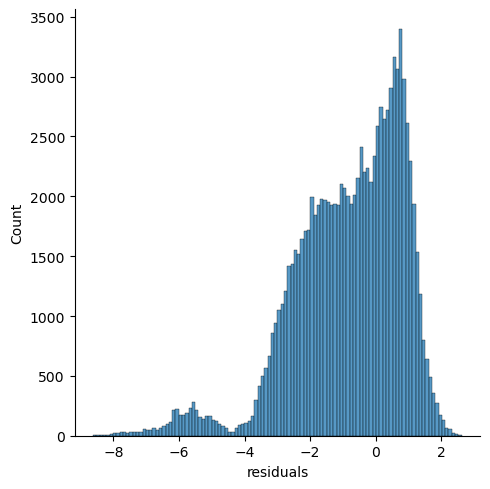

In [30]:
sns.displot(residuals['residuals'])

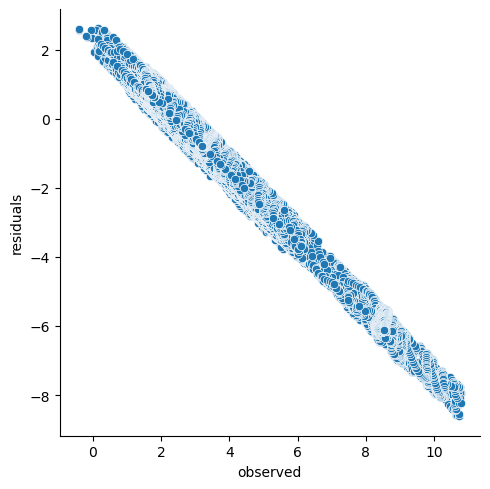

In [31]:
sns.relplot(data=residuals, x='observed', y='residuals')

## Exploratory PCA

In [32]:
pca, X_pca, pca_stats = perform_pca(X_train, 6)

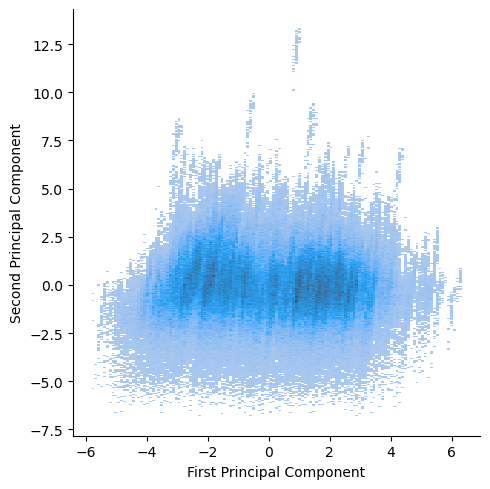

In [33]:
sns.displot(data=X_pca, x='pca0', y='pca1')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

In [34]:
pca_stats

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6
Explained Variance Ratio,0.201770,0.135583,0.129316,0.096799,0.085497,0.061982
ground_elev,0.001259,-0.126714,0.238587,-0.475739,0.330162,-0.042127
x,0.004701,-0.029992,0.100410,-0.433273,0.355940,-0.071909
y,-0.002337,0.067200,-0.136020,0.320060,-0.229782,0.039245
reg_clusters,-0.005064,0.023198,-0.058928,0.065434,0.031705,-0.088114
ini_years_water_depth_mean,-0.027307,-0.340428,0.422718,0.089723,-0.191617,0.064448
ini_years_water_depth_std,-0.009439,-0.022738,-0.010139,0.234049,-0.171887,-0.041368
ini_years_water_depth_min,-0.023380,-0.327903,0.423792,-0.019247,-0.105894,0.071466
ini_years_water_depth_max,-0.027703,-0.331303,0.404916,0.131404,-0.220745,0.057947
precip_mean,0.001830,0.271532,0.248045,0.200258,0.242621,0.296236


## Build initial pipelines

### Define preprocessing steps

In [33]:
#X_train.info()

In [34]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [35]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [36]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [37]:
regressors = [
    #('DecisionTree', DecisionTreeRegressor()), # not really good
    ('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    #('PLS', PLSRegression()),
    #('RandForest', RandomForestRegressor(n_estimators=30)), # best so far but costly (>10 min)
    #('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
    #('GBR', GradientBoostingRegressor()), # rel. slow and inferior to HGBR
    #('AdaBoost', AdaBoostRegressor()), # so far not good
    #('SVR' , SVR()), # extremely slow
    #('' ,()),
    #('' ,()),
    # try XGBoost
]

### Create a pipeline for each classifier

In [38]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [39]:
pipelines['LinReg']

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer()),
                                                                  ('num_scaler',
                                                                   StandardScaler())]),
                                                  Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('cat_encoder',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['reg_clusters'], dtype='object'))])),
                ('regressor', LinearRegression())])

## Inspect models

more or less stats from dummy model: 

MAE 1.180524150300254

RMSE 1.5993132760325228

MAPE 495545893932.64526

R2 -0.3085209566128313

In [40]:
predictions = {}
metrics = {}
residuals = {}

for name in pipelines:
    print(name)
    pipe = pipelines[name]

    #print('FITTING')
    pipe.fit(X_train, y_train)
    print('--- train data ---')
    calc_metrics(y_train, pipe.predict(X_train))

    #print('PREDICTING')
    y_pred = pipe.predict(X_test)

    # save
    print('--- test data ---')
    predictions[name] = y_pred
    metrics[name] = calc_metrics(y_test, y_pred)
    residuals[name] = calc_residuals(y_test, y_pred)

SGD
--- train data ---
MAE 0.557032405880601
RMSE 0.737791042042389
MAPE 47850991466.0747
R2 0.7606054844588721
--- test data ---
MAE 0.64980360025119
RMSE 0.9212073753924723
MAPE 0.23560219003961066
R2 0.5458560311019107
LinReg
--- train data ---
MAE 0.5551136365447435
RMSE 0.73622382445921
MAPE 42919889560.11359
R2 0.7616214491157152
--- test data ---
MAE 0.6457568891652075
RMSE 0.921850286429094
MAPE 0.23051409165311235
R2 0.5452219153488822


In [41]:
#residuals['DecisionTree']

In [42]:
compare_models = pd.DataFrame(metrics)
compare_models

,SGD,LinReg
MAE,0.649804,0.645757
RMSE,0.921207,0.921850
MAPE,0.235602,0.230514
R2,0.545856,0.545222


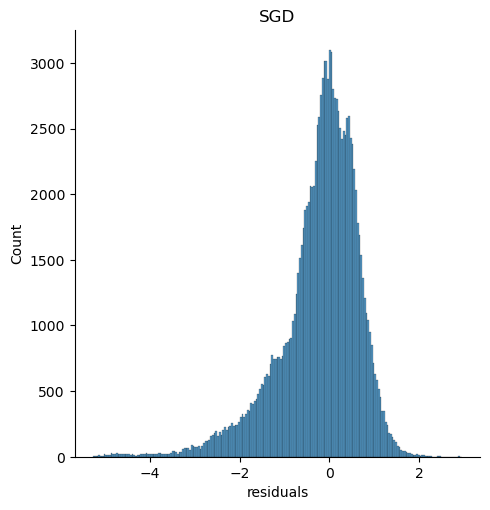

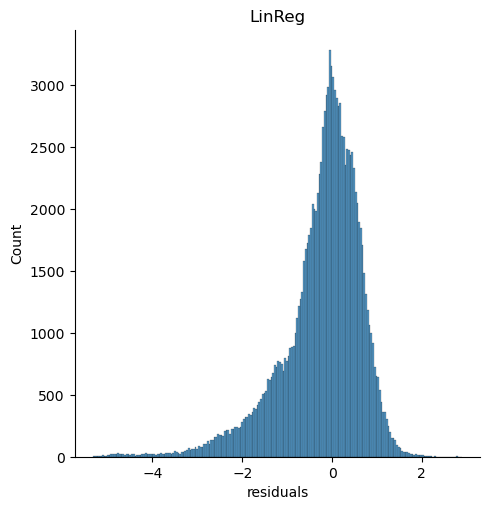

In [43]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

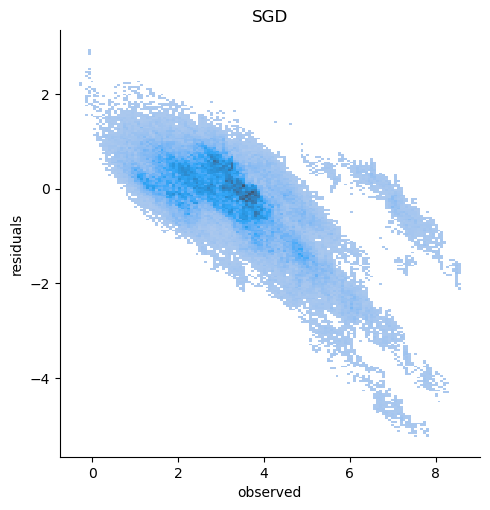

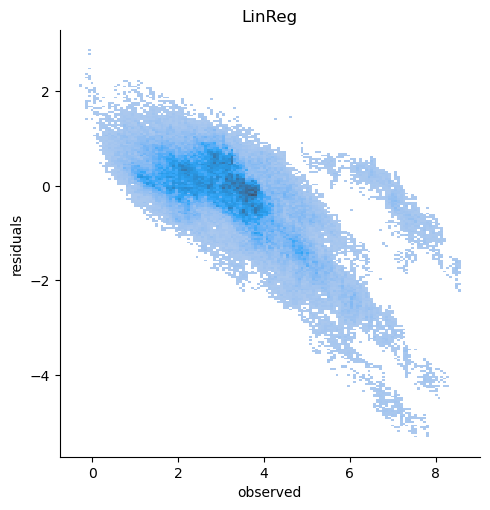

In [44]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

In [45]:
#residuals['HGBoost']

In [46]:
model = 'LinReg'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [47]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [48]:
#test.info()

In [49]:
#test.describe()

In [50]:
test.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,14176,1950-01-02,POINT (8.58855 49.59749),97.40,470267.000,5493961.000,1,2.284636,0.167471,1.84,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,2.34,3.667083,1.327083
1950-01-02,12902,1950-01-02,POINT (8.45423 49.72066),87.63,460660.483,5507716.036,11,2.117403,0.498628,1.03,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,3.03,2.727841,-0.302159
1950-01-04,13582,1950-01-04,POINT (8.50147 49.61739),92.91,463989.000,5496211.000,8,2.700833,0.291171,2.26,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,2.94,4.139034,1.199034
1950-01-04,13658,1950-01-04,POINT (8.50948 49.63252),93.14,464578.855,5497889.913,8,1.578772,0.284562,0.90,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,2.49,3.751434,1.261434
1950-01-04,12911,1950-01-04,POINT (8.48664 49.75174),90.32,463020.000,5511155.000,2,4.806732,0.630228,2.97,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,5.70,4.851547,-0.848453


In [51]:
test.station_id.unique()[0]

14176

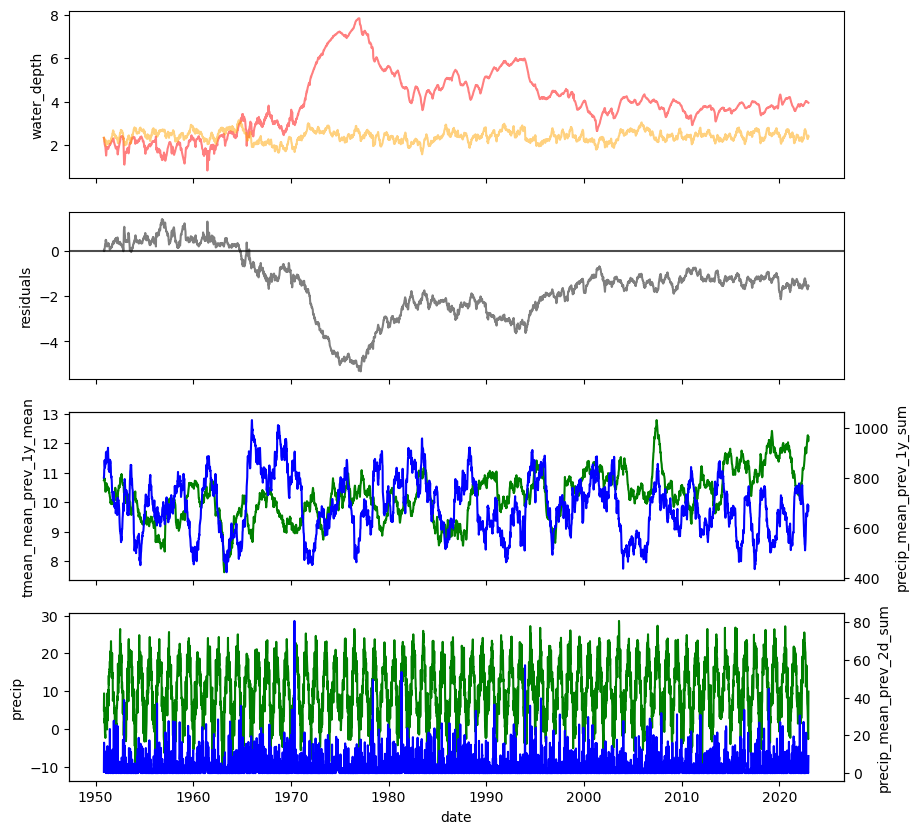

In [52]:
#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_2d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_2d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## Exploratory hyperparameter search

### Define preprocessing steps

In [53]:
# select categorical and numerical column names
#X_cat_columns = X_train.select_dtypes(exclude="number").columns
X_cat_columns = X_train.select_dtypes(include="int32").columns
X_num_columns = X_train.select_dtypes(include="float64").columns

# create numerical pipeline
num_pipe = Pipeline(
    steps=[('num_imputer', SimpleImputer(strategy='mean')), # probably not needed...
           #('num_scaler', MinMaxScaler())
           ('num_scaler', StandardScaler())
          ])

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = Pipeline(
    steps=[#('cat_imputer', SimpleImputer(strategy='constant', fill_value='na')),
            #('cat_imputer', SimpleImputer(strategy='constant', fill_value=0)), 
           ('cat_encoder', OneHotEncoder(drop='first', 
                                         sparse_output=False, 
                                         handle_unknown='ignore'))
           #('cat_encoder', OrdinalEncoder())
          ])

In [54]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipe, X_num_columns), 
        ('cat', categoric_pipe, X_cat_columns)
    ],
    #remainder='passthrough'
).set_output(transform='pandas')

In [55]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  SimpleImputer()),
                                                 ('num_scaler',
                                                  StandardScaler())]),
                                 Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',
       'moisture_mean', 'precip_mean_prev_2d_sum', 'precip_mean_prev_...
       'precip_mean_prev_1y_sum', 'precip_mean_prev_3y_sum',
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                ('cat',
                                 Pipeline(steps=[('cat_encoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['reg_clusters'], dtype='object'))])

### Define regressors to test

In [56]:
regressors = [
    #('SGD', SGDRegressor()),
    ('LinReg', LinearRegression()),
    #('HGBoost', HistGradientBoostingRegressor()), # excellent and very fast
]

### Create a pipeline for each regressor

In [57]:
pipelines = {}
for name, reg in regressors:
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        #('selector', SelectKBest(score_func=f_regression)),
        #('selector', RFECV(estimator=DecisionTreeRegressor())),
        #('feature_selection', SelectFromModel(DecisionTreeRegressor())),
        ('regressor', reg)
     ]).set_output(transform="pandas")
    pipelines[name] = pipeline


In [58]:
#pipelines['HGBoost']

### Define exploratory hyperparameters

In [59]:
param_grids_explore = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        #'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        'regressor__max_leaf_nodes': [5, 10, 30], # d=31
        'regressor__max_depth': [None, 5, 10], # d=None
        'regressor__min_samples_leaf': [5, 20, 50], # d=20
        'regressor__l2_regularization': [0, 0.1], # d=0
        #'regressor__max_bins': [255], # d=255
        #'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [60]:
# Fit and evaluate each pipeline
scores_explore = {}
params_explore = {}
estimator_explore = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_explore[name], 
                               cv=5, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_explore[name] = grid_search.best_score_
        params_explore[name] = grid_search.best_params_
        estimator_explore[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.6457568891652075
RMSE 0.921850286429094
MAPE 0.23051409165311235
R2 0.5452219153488822


In [61]:
scores_explore

{'LinReg': 0.7173173104294637}

In [62]:
pd.DataFrame(params_explore)

,LinReg


In [63]:
estimator_explore['LinReg']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['reg_clusters'], dtype='object'))])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={}, verbose=2)

In [64]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg
MAE,0.645757
MAPE,0.230514
R2,0.545222
RMSE,0.921850


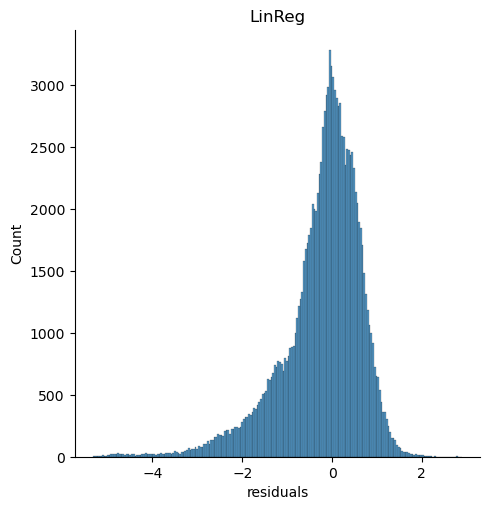

In [65]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

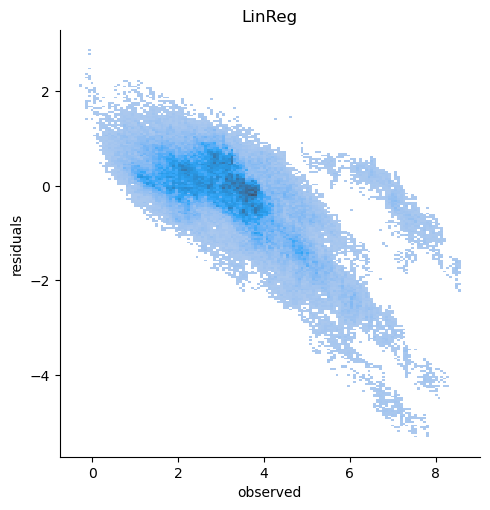

In [66]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [67]:
model = 'LinReg'
y_pred = predictions[model]
resid = residuals[model]

y_pred = pd.DataFrame(y_pred, columns=['pred_water_depth'])
y_pred.index = info_test.index
#y_pred

In [68]:
test = pd.concat([info_test, X_test, y_test, y_pred, resid['residuals']],
                 axis='columns')

In [69]:
#test.info()

In [70]:
#test.describe()

In [71]:
test.head()

,station_id,date,geometry,ground_elev,x,y,reg_clusters,ini_years_water_depth_mean,ini_years_water_depth_std,ini_years_water_depth_min,...,precip_mean_prev_3y_sum,tmean_mean_prev_2d_mean,tmean_mean_prev_7d_mean,tmean_mean_prev_30d_mean,tmean_mean_prev_90d_mean,tmean_mean_prev_1y_mean,tmean_mean_prev_3y_mean,water_depth,pred_water_depth,residuals
date,,,,,,,,,,,,,,,,,,,,,
1950-01-02,14176,1950-01-02,POINT (8.58855 49.59749),97.40,470267.000,5493961.000,1,2.284636,0.167471,1.84,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,2.34,3.667083,1.327083
1950-01-02,12902,1950-01-02,POINT (8.45423 49.72066),87.63,460660.483,5507716.036,11,2.117403,0.498628,1.03,...,1746.344286,-0.9375,2.825000,4.0775,6.524861,11.005240,10.748059,3.03,2.727841,-0.302159
1950-01-04,13582,1950-01-04,POINT (8.50147 49.61739),92.91,463989.000,5496211.000,8,2.700833,0.291171,2.26,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,2.94,4.139034,1.199034
1950-01-04,13658,1950-01-04,POINT (8.50948 49.63252),93.14,464578.855,5497889.913,8,1.578772,0.284562,0.90,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,2.49,3.751434,1.261434
1950-01-04,12911,1950-01-04,POINT (8.48664 49.75174),90.32,463020.000,5511155.000,2,4.806732,0.630228,2.97,...,1752.794286,3.3125,1.503571,3.7950,6.294028,11.008493,10.768790,5.70,4.851547,-0.848453


In [72]:
test.station_id.unique()[0]

14176

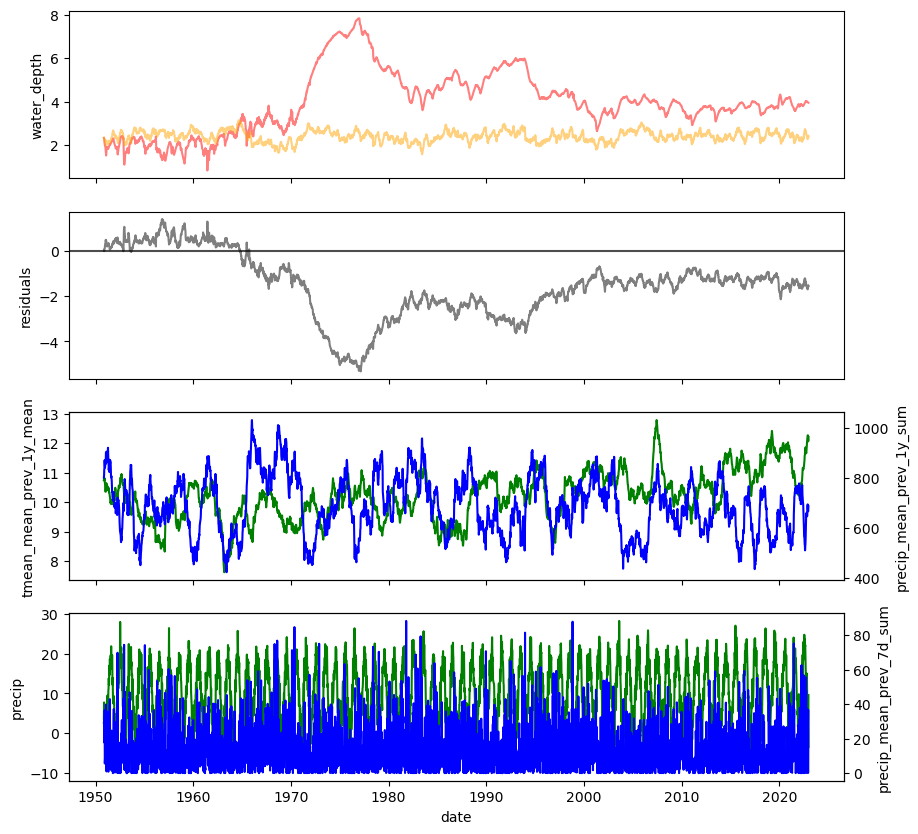

In [73]:
#data = test.loc[test.station_id == 13500]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_7d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_7d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## Refinement hyperparameter search

### Define refinement hyperparameters

In [74]:
param_grids_refine = {
    'SGD': {
        #'regressor__alpha': [0.00001, 0.001, 0.1], # d=0.0001
        #'regressor__penalty': ['l1', 'l2', 'elasticnet'], # d='l2'
        #'regressor__learning_rate': ['optimal', 'invscaling' 'adaptive'], # d=invscaling
        #'regressor__max_iter': [100, 1000, 3000], # d=1000
        #'regressor__tol': [1e-3, 1e-4, 1e-5], # d=1e-3
        #'regressor__loss': ['squared_epsilon_insensitive', 'epsilon_insensitive', 'squared_error'], # d=squared_error
        #'regressor__early_stopping': [True, False], # d=False
        #'regressor__validation_fraction': [0.1, 0.2], # d=0.1
        #'regressor__average': [True, False], # d=False
    },
    'LinReg': {
        # does not have tunable parameters
    },
    'HGBoost': {
        #'regressor__learning_rate': [0.01, 0.1, 0.2], # d=0.1
        'regressor__max_leaf_nodes': [3, 5, 7], # d=31
        'regressor__max_depth': [3, 5, 7], # d=None
        'regressor__min_samples_leaf': [3, 5, 7], # d=20
        'regressor__l2_regularization': [0, 0.05], # d=0
        #'regressor__max_bins': [255], # d=255
        #'regressor__categorical_features': list(str('cat__' + X_cat_columns.values))
        #TODO: try to get categorical_features running...
    }
}


### Fit and evaluate models

In [75]:
# Fit and evaluate each pipeline
scores_refine = {}
params_refine = {}
estimator_refine = {}
predictions = {}
metrics = {}
residuals = {}

fit_models = True # for turning off costly exploratory fitting

for name in pipelines:
    print(f"\nTraining and evaluating {name}...")
    pipe = pipelines[name]
    grid_search = GridSearchCV(pipe, 
                               param_grids_refine[name], 
                               cv=5, 
                               #scoring='neg_mean_absolute_error',
                               #scoring='neg_mean_squared_error',
                               #scoring='r2',
                               verbose=2, n_jobs=-1)
    
    if fit_models == True:
        grid_search.fit(X_train, y_train)
        
        # Evaluate on test set
        #y_pred = grid_search.predict(X_test)
        #accuracy = accuracy_score(y_test, y_pred)
        
        print("Best parameters found:")
        print(grid_search.best_params_)
        #print("Classification report:")
        #print(classification_report(y_test, y_pred))
        #print(f"Accuracy: {accuracy:.4f}")
        
        scores_refine[name] = grid_search.best_score_
        params_refine[name] = grid_search.best_params_
        estimator_refine[name] = grid_search

        print('--- predict test data ---')
        y_pred = grid_search.predict(X_test)
        predictions[name] = y_pred
        metrics[name] = calc_metrics(y_test, y_pred)
        residuals[name] = calc_residuals(y_test, y_pred)


Training and evaluating LinReg...
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best parameters found:
{}
--- predict test data ---
MAE 0.6457568891652075
RMSE 0.921850286429094
MAPE 0.23051409165311235
R2 0.5452219153488822


In [76]:
scores_refine

{'LinReg': 0.7173173104294637}

In [77]:
pd.DataFrame(params_refine)

,LinReg


In [78]:
estimator_refine['LinReg']

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('num_imputer',
                                                                                          SimpleImputer()),
                                                                                         ('num_scaler',
                                                                                          StandardScaler())]),
                                                                         Index(['ground_elev', 'x', 'y', 'ini_years_water_depth_mean',
       'ini_years_water_depth_std', 'ini_years_water_depth_min',
       'ini_years_water_depth_max', 'precip_mean', 'tmean_mean',...
       'tmean_mean_prev_2d_mean', 'tmean_mean_prev_7d_mean',
       'tmean_mean_prev_30d_mean', 'tmean_mean_prev_90d_mean',
       'tmean_mean_prev_1y_mean', 'tmean_mean_prev_3y_mean'],
      dtype='object')),
                                                                        ('cat',
                                                                         Pipeline(steps=[('cat_encoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         Index(['reg_clusters'], dtype='object'))])),
                                       ('regressor', LinearRegression())]),
             n_jobs=-1, param_grid={}, verbose=2)

In [79]:
compare_models = pd.DataFrame(metrics)
compare_models

,LinReg
MAE,0.645757
MAPE,0.230514
R2,0.545222
RMSE,0.921850


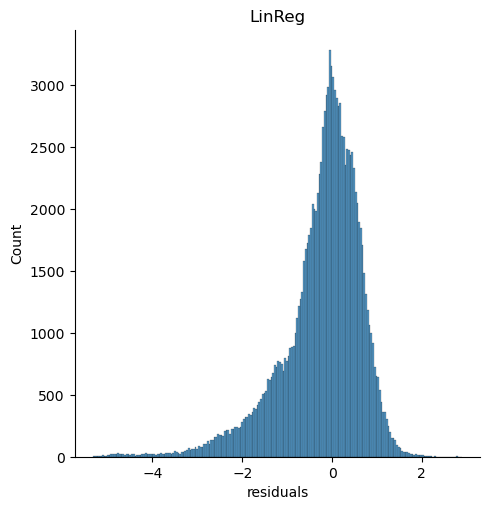

In [80]:
for name in residuals:
    #print(name)
    r = residuals[name]
    sns.displot(r['residuals']).set(title=name)

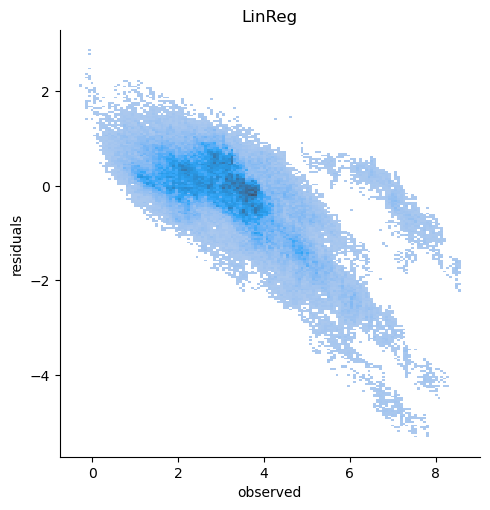

In [81]:
for name in residuals:
    r = residuals[name]
    #print(name, r.shape)
    sns.displot(data=r, x='observed', y='residuals').set(title=name)

### Analyse models

In [82]:
model = 'LinReg'

y_train_pred = estimator_refine[model].predict(X_train)
train_resid = calc_residuals(y_train, y_train_pred)

y_test_pred = estimator_refine[model].predict(X_test)
test_resid = calc_residuals(y_test, y_test_pred)

y_train_pred = pd.DataFrame(y_train_pred, columns=['pred_water_depth'])
y_train_pred.index = info_train.index

y_test_pred = pd.DataFrame(y_test_pred, columns=['pred_water_depth'])
y_test_pred.index = info_test.index
#y_pred

In [83]:
train = pd.concat([info_train, X_train, y_train, y_train_pred, train_resid['residuals']],
                 axis='columns')

test = pd.concat([info_test, X_test, y_test, y_test_pred, test_resid['residuals']],
                 axis='columns')

In [84]:
#train.info()

In [85]:
#test.info()

In [86]:
#train.describe()

In [87]:
#test.describe()

In [88]:
#train.head()

In [89]:
#test.head()

In [90]:
train.station_id.unique()[0]

13491

In [91]:
test.station_id.unique()[0]

14176

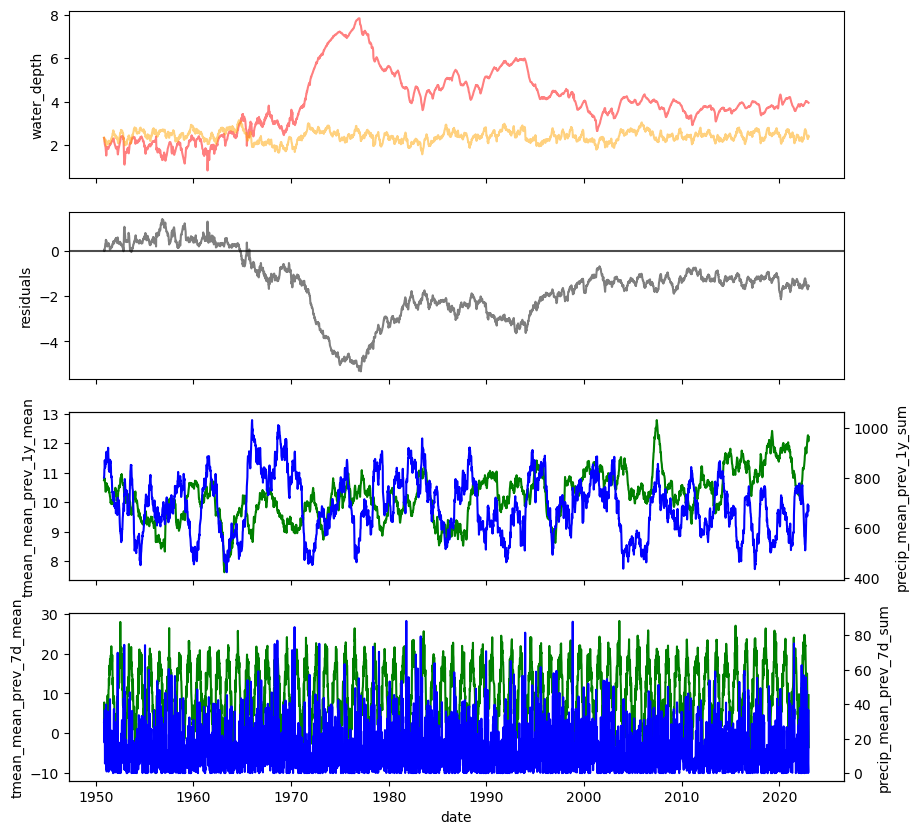

In [92]:
data = test.loc[test.station_id == 13500]

#data = train.loc[train.station_id == train.station_id.unique()[10]]
data = test.loc[test.station_id == test.station_id.unique()[10]]

# Create a figure and an axis
fig, ax = plt.subplots(4,1, figsize=(10, 10), sharex=True)

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='r', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="pred_water_depth",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='orange', alpha=0.5,
             data=data,
             ax=ax[0])

# Plot the first DataFrame on the primary y-axis
sns.lineplot(x="date", y="residuals",
             #hue="station_id", 
             #style="event",
             #palette='tab10',
             color='k', alpha=0.5,
             data=data,
             ax=ax[1])

ax[1].axhline(y=0, color='k', alpha=0.7)
# Create a secondary y-axis
#ax[1] = ax[0].twinx()

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_1y_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='g'
            )

# Create a secondary y-axis
ax[2] = ax[2].twinx()

sns.lineplot(x="date", y="precip_mean_prev_1y_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[2], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Plot the second DataFrame on the secondary y-axis
sns.lineplot(x="date", y="tmean_mean_prev_7d_mean", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='g'
            )

# Create a secondary y-axis
ax[3] = ax[3].twinx()

sns.lineplot(x="date", y="precip_mean_prev_7d_sum", 
             data=data,#['1983-01':'1985-01'], # filter dates here
             ax=ax[3], 
             color='b'
            )

# Optionally, set labels for the y-axes
#ax[3].set_ylabel('precip')
#ax2.set_ylabel('Y2 Label')

# Set the x-axis limits
start_date = pd.to_datetime('2000-01-01')
end_date = pd.to_datetime('2020-01-10')
#start_date = pd.to_datetime('1950-01-01')
#end_date = pd.to_datetime('1970-01-10')
#plt.xlim(start_date, end_date)

# Show the plot
plt.show()

## Analyze station variability

In [93]:
#df = train.copy()
df = test.copy()
geos = df[['station_id', 'geometry']]

#df.columns.unique()
geos.head()

,station_id,geometry
date,,
1950-01-02,14176,POINT (8.58855 49.59749)
1950-01-02,12902,POINT (8.45423 49.72066)
1950-01-04,13582,POINT (8.50147 49.61739)
1950-01-04,13658,POINT (8.50948 49.63252)
1950-01-04,12911,POINT (8.48664 49.75174)


In [94]:
stats = df[['station_id', #'geometry',
    'water_depth', 'pred_water_depth',
    'residuals']].groupby('station_id'
                          ).agg({'water_depth': ['mean', 'std', 'min', 'max'],
                                 'pred_water_depth': ['mean', 'std', 'min', 'max'],
                                 'residuals': ['mean', 'std', 'min', 'max']})

stats.columns = ['_'.join(col).strip() for col in stats.columns.values]
stats = pd.merge(left=stats, right=geos, on='station_id', how='left')
stats.head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
0,12902,2.106839,0.625092,0.32,3.53,2.314496,0.245281,1.56778,3.060407,0.207657,0.502741,-1.121702,2.005844,POINT (8.45423 49.72066)
1,12902,2.106839,0.625092,0.32,3.53,2.314496,0.245281,1.56778,3.060407,0.207657,0.502741,-1.121702,2.005844,POINT (8.45423 49.72066)
2,12902,2.106839,0.625092,0.32,3.53,2.314496,0.245281,1.56778,3.060407,0.207657,0.502741,-1.121702,2.005844,POINT (8.45423 49.72066)
3,12902,2.106839,0.625092,0.32,3.53,2.314496,0.245281,1.56778,3.060407,0.207657,0.502741,-1.121702,2.005844,POINT (8.45423 49.72066)
4,12902,2.106839,0.625092,0.32,3.53,2.314496,0.245281,1.56778,3.060407,0.207657,0.502741,-1.121702,2.005844,POINT (8.45423 49.72066)


In [95]:
stats = gpd.GeoDataFrame(stats, geometry=stats['geometry'], crs='EPSG:4326')

In [96]:
stats.sort_values(by='residuals_mean').head()

,station_id,water_depth_mean,water_depth_std,water_depth_min,water_depth_max,pred_water_depth_mean,pred_water_depth_std,pred_water_depth_min,pred_water_depth_max,residuals_mean,residuals_std,residuals_min,residuals_max,geometry
58261,13582,5.538712,1.361023,2.4,8.29,3.766119,0.247317,2.938378,4.513301,-1.772592,1.370978,-4.490978,1.366569,POINT (8.50147 49.61739)
58422,13582,5.538712,1.361023,2.4,8.29,3.766119,0.247317,2.938378,4.513301,-1.772592,1.370978,-4.490978,1.366569,POINT (8.50147 49.61739)
58423,13582,5.538712,1.361023,2.4,8.29,3.766119,0.247317,2.938378,4.513301,-1.772592,1.370978,-4.490978,1.366569,POINT (8.50147 49.61739)
58424,13582,5.538712,1.361023,2.4,8.29,3.766119,0.247317,2.938378,4.513301,-1.772592,1.370978,-4.490978,1.366569,POINT (8.50147 49.61739)
58425,13582,5.538712,1.361023,2.4,8.29,3.766119,0.247317,2.938378,4.513301,-1.772592,1.370978,-4.490978,1.366569,POINT (8.50147 49.61739)


In [97]:
# Load hillshade DEM
dem, dem_extent = load_dem('./data/dem/bergstraße30_shaded.tif')

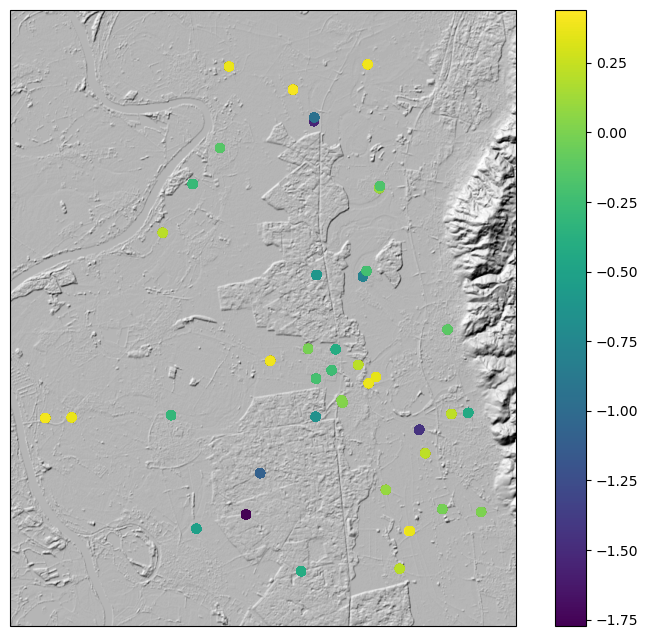

In [98]:
extent = stats.geometry.total_bounds

# Create a figure and axis with a PlateCarree projection
fig, ax = plt.subplots(figsize=(10, 8), 
                       subplot_kw={'projection': ccrs.PlateCarree()} # removes axis labels
                      )

# Plot hillshade DEM
ax.imshow(dem, extent=(dem_extent[0], dem_extent[2],
                       dem_extent[1], dem_extent[3]),
          cmap='gray', origin='upper', aspect='auto')

stats.plot(column='residuals_mean',
            #cmap='coolwarm',
            legend=True, 
            ax=ax)

ax.set_xlim(extent[0]-0.02, extent[2]+0.02)
ax.set_ylim(extent[1]-0.02, extent[3]+0.02)

#ax.legend(loc='lower left', framealpha=0.5)

#plt.title('Average water depth (m)')
#plt.savefig('./figs/map_mean_water_depth_all_stations.png', bbox_inches='tight')

# Show the plot
plt.show()

## TODO

- implement location encoding by
    - discretizing x and y (pd.cut) and bucketing --> x-y grid
    - DONE performing clustering on the points with dbscan, kmean, knn, ...
- try to predict water_depth_anomaly?
- try with lag-shifted data...
- hyperparameter search
- examine model accuracy (min/max/std of resids, ...) of each station

## Lessons learned

hyperparameters

- HGBoost works well, but is still not fast enough for grid search while input data is optimized.
- first use linreg until all is good